In [96]:
#importamos librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import auc_score
from lightfm.data import Dataset
import time
import lightfm.cross_validation as cross_val


In [59]:
megusta = pd.read_csv('./megusta.csv', delimiter=",", encoding="utf-8")
perros = pd.read_csv('./RDB.csv', delimiter=",", encoding="utf-8")
usuario = pd.read_csv('./usuario.csv', delimiter=",", encoding="utf-8")
ustage = pd.read_csv('./user_stage.csv', delimiter=",", encoding="utf-8")
app_user = pd.read_csv('./app_user.csv', delimiter=",", encoding="utf-8")

In [60]:
perros = perros.drop(['Nombre', 'Raza', 'Necesidades', 'cluster', 'Fundacion'], axis=1)
perros['atencionesEspeciales'] = perros['atencionesEspeciales'].apply(lambda x: "si" if x == 1 else "no")
perros['ninos'] = perros['ninos'].apply(lambda x: "si" if x == 1 else "no")
perros['entrenado'] = perros['entrenado'].apply(lambda x: "si" if x == 1 else "no")
perros['esterilizado'] = perros['esterilizado'].apply(lambda x: "si" if x == 1 else "no")
perros['perros'] = perros['perros'].apply(lambda x: "si" if x == 1 else "no")
perros['actividad'] = perros['actividad'].apply(lambda x: "si" if x == 1 else "no")
perros['rangoEdadPerro']=perros['Edad'].apply(lambda x: "a" if x<5 else ( "b" if (x>=5 and x<10) else "c"))
perros = pd.get_dummies(perros, columns =  ['Tamano', 'Sexo', 'Color', 'Pelaje', 'Agresividad', 'atencionesEspeciales', 'ninos', 'entrenado', 'esterilizado', 'perros', 'actividad', 'rangoEdadPerro'], drop_first=True)
megusta = megusta.drop(['rated_date'], axis = 1)
megusta= megusta.drop_duplicates()
usuario = usuario.drop(['cluster', 'ciclovia', 'locha', 'disciplina', 'silencio', 'amigos', 'pyState'], axis=1)
usuario = pd.merge(usuario, ustage, on='userid')
usuario = pd.merge(usuario, app_user, on='userid')

In [61]:
# borramos los usuarios que les gusta todo y les gusta nada
mean_rate=[]
for index, row in usuario.iterrows():
    m = megusta[megusta['userid']==row['userid']]['megusta'].mean()
    mean_rate.append(m)
usuario['mean_rate']=mean_rate
usuario = pd.merge(usuario, megusta, on='userid')
indexUserid = usuario[ (usuario['userid'] <16)].index
usuario.drop(indexUserid , inplace=True)
indexUserid = usuario[ (usuario['mean_rate'] == 5.000000) | (usuario['mean_rate'] == 1.000000) ].index
usuario.drop(indexUserid , inplace=True)
usuario.head()

,userid,viajes,tipofamilia,actividad,salir,estilo,vivienda,estrato,sueldo,trabajo,fpy,edad,stage,provider,mean_rate,perroid,megusta
288,18,1.0,sin hijos,CINE,OUTDOOR,orden,APARTAMENTO,Estrato 4,c,WFH,NaN,41.0,2,facebook,4.666667,480,5
289,18,1.0,sin hijos,CINE,OUTDOOR,orden,APARTAMENTO,Estrato 4,c,WFH,NaN,41.0,2,facebook,4.666667,63,5
290,18,1.0,sin hijos,CINE,OUTDOOR,orden,APARTAMENTO,Estrato 4,c,WFH,NaN,41.0,2,facebook,4.666667,192,5
291,18,1.0,sin hijos,CINE,OUTDOOR,orden,APARTAMENTO,Estrato 4,c,WFH,NaN,41.0,2,facebook,4.666667,341,1
292,18,1.0,sin hijos,CINE,OUTDOOR,orden,APARTAMENTO,Estrato 4,c,WFH,NaN,41.0,2,facebook,4.666667,234,5


In [62]:
megusta = usuario[['userid', 'perroid', 'megusta']].copy()
megusta.head()

,userid,perroid,megusta
288,18,480,5
289,18,63,5
290,18,192,5
291,18,341,1
292,18,234,5


In [63]:
usuario = usuario.drop(['fpy', 'stage', 'provider', 'mean_rate', 'perroid', 'megusta'], axis=1)
usuario = usuario.drop_duplicates()
usuario.head()

,userid,viajes,tipofamilia,actividad,salir,estilo,vivienda,estrato,sueldo,trabajo,edad
288,18,1.0,sin hijos,CINE,OUTDOOR,orden,APARTAMENTO,Estrato 4,c,WFH,41.0
312,17,1.0,sin hijos,NETFLIX,INDOOR,desorden,APARTAMENTO,Estrato 6,b,OFICINA,40.0
353,21,1.0,hijos,NETFLIX,OUTDOOR,desorden,CASA,Estrato 4,a,WFH,22.0
387,22,0.0,hijos,NETFLIX,INDOOR,orden,CASA,Estrato 4,c,WFH,55.0
423,23,0.0,sin hijos,CINE,INDOOR,orden,APARTAMENTO,Estrato 3,a,WFH,19.0


In [64]:
# sacamos una variable categorica de la edad de los usuarios y obtenemos dummies de las variables categoricas
usuario['rangoEdadH']=usuario['edad'].apply(lambda x: "a" if x<20 else ( "b" if (x>=20 and x<30) else ( "c" if (x>=30 and x<40) else "d")))
usuario['viajes'] = usuario['viajes'].apply(lambda x: "y" if x == 1 else "n")
usuario = pd.get_dummies(usuario, columns =  ['viajes', 'tipofamilia', 'actividad', 'salir', 'estilo', 'vivienda', 'estrato', 'sueldo', 'trabajo', 'rangoEdadH'], drop_first=True)
usuario.head()

,userid,edad,viajes_y,tipofamilia_sin hijos,actividad_NETFLIX,salir_OUTDOOR,estilo_orden,vivienda_CASA,estrato_Estrato 2,estrato_Estrato 3,estrato_Estrato 4,estrato_Estrato 5,estrato_Estrato 6,sueldo_b,sueldo_c,trabajo_WFH,rangoEdadH_b,rangoEdadH_c,rangoEdadH_d
288,18,41.0,1,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1
312,17,40.0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1
353,21,22.0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0
387,22,55.0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,0,1
423,23,19.0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [65]:
# Preparamos los datasets para ser usados por la libreria LightFM
megusta.rename(
    columns={"userid": "user_id", "perroid": "item_id", "megusta": "rating"},
    inplace=True,
)
megusta.head()

,user_id,item_id,rating
288,18,480,5
289,18,63,5
290,18,192,5
291,18,341,1
292,18,234,5


In [18]:
item_features_current = perros[perros["perroid"].isin(megusta["item_id"])]
user_features_current = usuario[usuario["userid"].isin(megusta["user_id"])]
user_ids_buffered = megusta['user_id'].unique()
item_ids_buffered = megusta['item_id'].unique()
item_feature_names = perros.columns.tolist()
item_feature_names.remove('perroid')
user_feature_names = usuario.columns.tolist()
user_feature_names.remove('userid')


In [21]:
dataset = Dataset()
dataset.fit(
    users=user_ids_buffered,
    items=item_ids_buffered,
    item_features=item_feature_names,
    user_features=user_feature_names
)

In [66]:
def transform_interactions(interactions):
    # Transforma las interacciones de la forma que necestia build_interactions
    #Retora un iterable de tuples  ("user_id", "pratilipi_id", 'read_percent').
    return interactions[["user_id", "item_id", 'rating']].itertuples(index=False)

In [67]:
interaction_matrix_current, _ = dataset.build_interactions(
    transform_interactions(megusta))

In [68]:
def transform_features(features, id_name):
    # Transfotma las caracteristicas de la forma que necesita build_item_features o build_user_features
    # Retorna un iterable de tuples (id, [list of feature names that has value 1]).
    transformed_features = []
    for row in features.to_dict(orient="records"):
        id_value = row[id_name]
        del row[id_name]
        feature_names = [key for key, value in row.items() if value == 1]
        transformed_features.append(
            (id_value, feature_names)
        )
    return transformed_features

In [70]:
tf = transform_features(item_features_current, "perroid")
uf = transform_features(user_features_current, "userid")

In [71]:
uf

[(18,
  ['viajes_y',
   'tipofamilia_sin hijos',
   'salir_OUTDOOR',
   'estilo_orden',
   'estrato_Estrato 4',
   'sueldo_c',
   'trabajo_WFH',
   'rangoEdadH_d']),
 (17,
  ['viajes_y',
   'tipofamilia_sin hijos',
   'actividad_NETFLIX',
   'estrato_Estrato 6',
   'sueldo_b',
   'rangoEdadH_d']),
 (21,
  ['viajes_y',
   'actividad_NETFLIX',
   'salir_OUTDOOR',
   'vivienda_CASA',
   'estrato_Estrato 4',
   'trabajo_WFH',
   'rangoEdadH_b']),
 (22,
  ['actividad_NETFLIX',
   'estilo_orden',
   'vivienda_CASA',
   'estrato_Estrato 4',
   'sueldo_c',
   'trabajo_WFH',
   'rangoEdadH_d']),
 (23,
  ['tipofamilia_sin hijos',
   'estilo_orden',
   'estrato_Estrato 3',
   'trabajo_WFH']),
 (25,
  ['tipofamilia_sin hijos',
   'actividad_NETFLIX',
   'vivienda_CASA',
   'estrato_Estrato 3',
   'sueldo_c',
   'trabajo_WFH',
   'rangoEdadH_c']),
 (24,
  ['tipofamilia_sin hijos',
   'salir_OUTDOOR',
   'estilo_orden',
   'vivienda_CASA',
   'estrato_Estrato 3',
   'sueldo_b',
   'trabajo_WFH',
   

In [72]:
# se obtiene la matriz de caracteristicas de los perros y de los usuarios
item_features_matrix_current = dataset.build_item_features(
    tf, normalize=False)
user_features_matrix_current = dataset.build_user_features(
    uf, normalize=False)
# se divide la matriz de interacciones en train y test
(train, test) = cross_val.random_train_test_split(interaction_matrix_current, 0.2, random_state=123)

In [73]:
test

<83x466 sparse matrix of type '<class 'numpy.int32'>'
	with 702 stored elements in COOrdinate format>

In [37]:
item_features_matrix_current.shape[1]

490

In [38]:
if not warp_model.item_embeddings.shape[0] == item_features_matrix_current.shape[1]:
    print('entre')

In [74]:
# utilizamos la libreria LightFM, se entrena el modelo con la matriz de interacciones y la matriz de caracteristicas de los perros y de los usuarios
# se obtiene el AUC para el modelo entrenado
# se repite el proceso para diferentes valores de alpha y epochs
# se obtiene el tiempo de entrenamiento para cada modelo
# esto se realiza para Wrap ( Weighted Approximate-Rank Pairwise ) y BPR (Bayesian Personalised Ranking)
alpha = 1e-05
epochs = 20
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, item_features = item_features_matrix_current, user_features=user_features_matrix_current, epochs=epoch)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, train, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean())
    
for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, item_features = item_features_matrix_current, user_features=user_features_matrix_current, epochs=epoch)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, train, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean())

In [75]:
# se obtiene las metricas de los dos modelos para train y test
df_result = pd.DataFrame(columns = ['Model', 'Evaluation Metric', 'Train', 'Test'])
auc_train_wrap = auc_score(warp_model, train, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
auc_test_wrap = auc_score(warp_model, test, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
precision_train_wrap = precision_at_k(warp_model, train, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
precision_test_wrap = precision_at_k(warp_model, test, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
recall_train_wrap = recall_at_k(warp_model, train, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
recall_test_wrap = recall_at_k(warp_model, test, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
auc_train_brp = auc_score(bpr_model, train, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
auc_test_brp = auc_score(bpr_model, test, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
precision_train_brp = precision_at_k(bpr_model, train, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
precision_test_brp = precision_at_k(bpr_model, test, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
recall_train_brp = recall_at_k(bpr_model, train, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
recall_test_brp = recall_at_k(bpr_model, test, k = 10, item_features = item_features_matrix_current, user_features=user_features_matrix_current).mean()
df_result = df_result.append(pd.DataFrame([['Wrap model', 'AUC', auc_train_wrap, auc_test_wrap],
                                           ['Wrap model', 'Precision@10', precision_train_wrap, precision_test_wrap],
                                           ['Wrap model', 'recall@10', recall_train_wrap, recall_test_wrap],
                                           ['brp model', 'AUC', auc_train_brp, auc_test_brp],
                                           ['brp model', 'Precision@10', precision_train_brp, precision_test_brp],
                                           ['brp model', 'recall@10', recall_train_brp, recall_test_brp],],
                                          columns = df_result.columns
                                         )
                            )
df_result

/tmp/ipykernel_11/3672383687.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(pd.DataFrame([['Wrap model', 'AUC', auc_train_wrap, auc_test_wrap],


,Model,Evaluation Metric,Train,Test
0,Wrap model,AUC,0.999996,0.743033
1,Wrap model,Precision@10,0.967470,0.003704
2,Wrap model,recall@10,0.572713,0.006173
3,brp model,AUC,0.984107,0.764517
4,brp model,Precision@10,0.703614,0.008642
5,brp model,recall@10,0.340798,0.022977


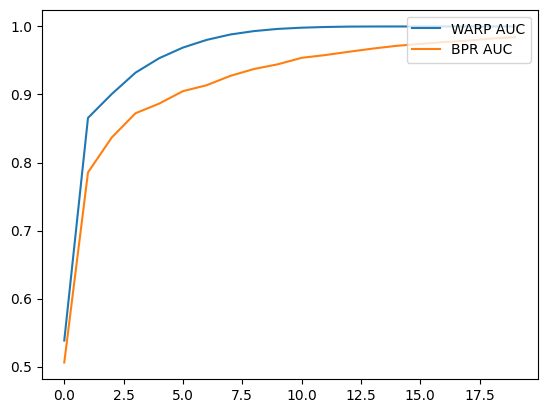

In [76]:
# se grafica el AUC para los dos modelos
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()